In [1]:
import pandas as pd
import numpy as np
from pprint import pprint
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import facts
from facts.clean import clean_dataset
from facts import valid_ifthens_with_coverage_correctness, rules2rulesbyif
from facts.models import customLogisticRegression
from facts.parameters import ParameterProxy
from facts.formatting import recourse_report_reverse, print_recourse_report, print_recourse_report_cumulative,print_recourse_report_KStest_cumulative
from facts.utils import load_rules_by_if, save_rules_by_if

import matplotlib.pyplot as plt

from IPython.display import Markdown, display

In [2]:
filename = Path(".") / "statlog+german+credit+data" / "german.data"
column_names = [
    "status",
    "duration",
    "hist",
    "purpose",
    "credit",
    "savings",
    "empl",
    "rate",
    "sex",
    "others",
    "residence",
    "property",
    "age",
    "plans",
    "housing",
    "cards",
    "job",
    "liables",
    "telephone",
    "foreign",
    "target"
]
df = pd.read_csv(filename, sep=" ", header=None, names=column_names)
df["sex"] = df.sex.map({"A91": "Male", "A92": "Female", "A93": "Male", "A94": "Male", "A95": "Female"})
df["target"] = df.target.map({1: 1, 2: 0})

df.head()

,status,duration,hist,purpose,credit,savings,empl,rate,sex,others,...,property,age,plans,housing,cards,job,liables,telephone,foreign,target
0,A11,6,A34,A43,1169,A65,A75,4,Male,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,Female,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,0
2,A14,12,A34,A46,2096,A61,A74,2,Male,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,Male,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,Male,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,0


In [3]:
y = df['target']
X = df.drop('target', axis=1)

num_features = X._get_numeric_data().columns.to_list()
cate_features = X.select_dtypes(include=['object','category']).columns.to_list()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=None, stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [4]:
%%time

model = customLogisticRegression(max_iter = 1500)
model.fit(X_train, y_train, cate_columns=cate_features, target_column='income')
model.predict(X_test.iloc[:100, :])

CPU times: total: 62.5 ms
Wall time: 73 ms


array([1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1.])

In [5]:
positive_label = 1
negative_label = 0
preds_Xtest = model.predict(X_test)
print(classification_report(y_test.map({negative_label: 0, positive_label: 1}), preds_Xtest))

              precision    recall  f1-score   support

           0       0.62      0.51      0.56        90
           1       0.81      0.87      0.83       210

    accuracy                           0.76       300
   macro avg       0.71      0.69      0.70       300
weighted avg       0.75      0.76      0.75       300



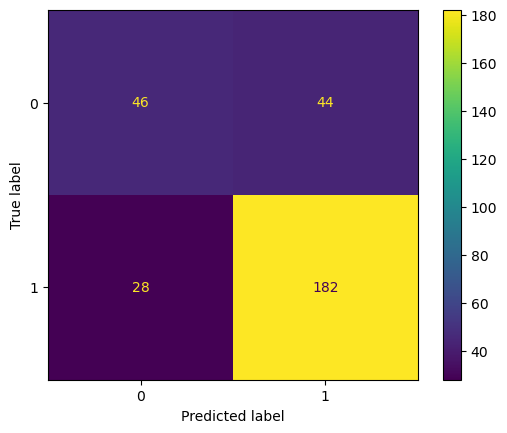

In [6]:
conf_matrix = confusion_matrix(y_test, preds_Xtest)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

In [7]:
from facts.misc import freqitemsets_with_supports

In [8]:
affected_males = X_test[(preds_Xtest == 0) & (X_test["sex"] == "Male")]
affected_females = X_test[(preds_Xtest == 0) & (X_test["sex"] == "Female")]
unaffected = X_test[preds_Xtest == 1]

In [9]:
len(freqitemsets_with_supports(affected_females, min_support=0.04)[0])

482575

In [10]:
#Uncomment if you want to find new rules with different support

ifthens_coverage_correctness = valid_ifthens_with_coverage_correctness(
    X_test,
    model=model,
    sensitive_attribute='sex',
    freqitem_minsupp = 0.04,
    missing_subgroup_val="Unknown",
    drop_infeasible = False,
    drop_above = False
)

print(f"Number of if-then pairs: {len(ifthens_coverage_correctness)}")
rules_by_if = rules2rulesbyif(ifthens_coverage_correctness)
print(f"Number of final subgroups: {len(rules_by_if.keys())}")

Computing frequent itemsets for each subgroup of the affected instances.


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.94s/it]

Number of frequent itemsets for affected: {'Female': 241287, 'Male': 244777}
Computing the intersection between the frequent itemsets of each subgroup of the affected instances.



100%|██████████████████████████████████████████████████████████████████████| 241287/241287 [00:00<00:00, 993739.27it/s]


Number of groups from the intersection: 36970
Number of frequent itemsets for the unaffected: 83631
Computing all valid if-then pairs between the common frequent itemsets of each subgroup of the affected instances and the frequent itemsets of the unaffacted instances.


100%|█████████████████████████████████████████████████████████████████████████| 36970/36970 [00:01<00:00, 22933.87it/s]

Computing correctenesses for all valid if-thens.



100%|█████████████████████████████████████████████████████████████████████████| 117143/117143 [11:33<00:00, 168.84it/s]


Number of if-then pairs: 117143
Number of final subgroups: 31509


In [ ]:
## Use this for loading rules from disk
# rules_by_if = load_rules_by_if("rules-german-credit.data")

## Use this for saving rules on disk
# save_rules_by_if("rules-german-credit.data", rules_by_if)

## Fairness definitions based on cumulative distribution of cost - correctness

## Calculation of cumulative correctness for all if clauses

In [11]:
# num_features = ['education-num', 'capital-gain', 'capital-loss']
# cate_features = ['age', 'Workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
# ord_features = ['hours-per-week']
ord_features = []

In [12]:
feature_weights = {}
features_with_binary_cost = cate_features
features_with_proportional_cost = num_features

comparators = facts.feature_change_builder(
    X_test,
    num_cols=features_with_proportional_cost,
    cate_cols=features_with_binary_cost,
    ord_cols=ord_features,
    feature_weights=feature_weights,
    num_normalization=True
)
params = ParameterProxy(featureChanges=comparators)

In [13]:
rules_with_cumulative = facts.cum_corr_costs_all(rules_by_if, X_test, model, sensitive_attribute="sex", params=params)

100%|████████████████████████████████████████████████████████████████████████████| 31509/31509 [07:35<00:00, 69.19it/s]


In [14]:
## Use this for loading rules from disk
# rules_with_cumulative = load_rules_by_if("rules-german-credit-cumulative.data")

## Use this for saving rules on disk
# save_rules_by_if("rules-german-credit-cumulative.data", rules_with_cumulative)

In [15]:
facts.update_costs_cumulative(rules_with_cumulative, params)

# Fairness of Mean Recourse ($c_\infty$ implementation)

In [27]:
import time

In [28]:
start = time.time()

In [29]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative,
    metric="fairness-of-mean-recourse-cinf",
    c_inf=5,
    sort_strategy="generic-sorting",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        # "remove-fair-rules"
    ],
    params=params
)

pop_sizes = {sg: ((X_test["sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["sex"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=False,
    correctness_metric=False
)

If cards = 1, hist = A32, liables = 1, plans = A141:
	Protected Subgroup 'Female', 9.68% covered out of 31
		Make plans = A143 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make cards = 2, plans = A143 with effectiveness 0.00% and counterfactual cost = 1.33.
		Make hist = A34, plans = A143 with effectiveness 0.00% and counterfactual cost = 2.0.
		Make cards = 2, hist = A34, plans = A143 with effectiveness 0.00% and counterfactual cost = 2.33.
		Make cards = 2, hist = A34, liables = 2, plans = A143 with effectiveness 0.00% and counterfactual cost = 3.33.
		Aggregate cost of the above recourses = 16.67
	Protected Subgroup 'Male', 6.98% covered out of 43
		Make plans = A143 with effectiveness 33.33% and counterfactual cost = 1.0.
		Make cards = 2, plans = A143 with effectiveness 66.67% and counterfactual cost = 1.33.
		Make hist = A34, plans = A143 with effectiveness 100.00% and counterfactual cost = 2.0.
		Make cards = 2, hist = A34, plans = A143 with effectiveness 100.00% an

# Fairness of Mean Recourse ("conditional expectation" implementation)

In [30]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative,
    metric="fairness-of-mean-recourse-conditional",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=10,
    filter_sequence = [
        "remove-contained",
        # "remove-fair-rules"
    ],
    params=params
)

pop_sizes = {sg: ((X_test["sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["sex"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=False,
    correctness_metric=False
)

If hist = A32, liables = 1, property = A122, telephone = A191:
	Protected Subgroup 'Female', 12.90% covered out of 31
		Make property = A123 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make telephone = A192 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make property = A121 with effectiveness 25.00% and counterfactual cost = 1.0.
		Make hist = A34 with effectiveness 25.00% and counterfactual cost = 1.0.
		Make property = A123, telephone = A192 with effectiveness 25.00% and counterfactual cost = 2.0.
		Make hist = A34, property = A123 with effectiveness 25.00% and counterfactual cost = 2.0.
		Make hist = A34, property = A123, telephone = A192 with effectiveness 25.00% and counterfactual cost = 3.0.
		Make hist = A34, liables = 2, property = A121 with effectiveness 25.00% and counterfactual cost = 3.0.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'Male', 4.65% covered out of 43
		Make property = A121 with effectiveness 0.00% and counterfactu

## Fairness of Coverage

In [31]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative,
    metric="total-correctness",
    sort_strategy="generic-sorting-ignore-forall-subgroups-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        # "remove-fair-rules",
        # "keep-only-min-change"
    ],
    params=params
)

pop_sizes = {sg: ((X_test["sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["sex"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=False,
    correctness_metric= True
)

If cards = 2, liables = 1, residence = 4, savings = A61:
	Protected Subgroup 'Female', 16.13% covered out of 31
		Make cards = 1 with effectiveness 0.00% and counterfactual cost = 0.33.
		Make residence = 2 with effectiveness 0.00% and counterfactual cost = 0.67.
		Make cards = 1, residence = 2 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make savings = A65 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make cards = 1, residence = 1 with effectiveness 0.00% and counterfactual cost = 1.33.
		Make cards = 1, savings = A65 with effectiveness 0.00% and counterfactual cost = 1.33.
		Aggregate cost of the above recourses = 0.00
	Protected Subgroup 'Male', 4.65% covered out of 43
		Make cards = 1 with effectiveness 0.00% and counterfactual cost = 0.33.
		Make residence = 2 with effectiveness 0.00% and counterfactual cost = 0.67.
		Make cards = 1, residence = 2 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make savings = A65 with effectiveness 100.00% and co

## Fairness of Recourse at Coverage Level 

In [32]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative,
    metric="min-above-corr",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-fair-rules",
        "keep-cheap-rules-above-thr-cor",
        # "keep-only-min-change",
        
    ],
    cor_threshold = 0.3,
    params=params
)

pop_sizes = {sg: ((X_test["sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["sex"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=False,
    correctness_metric=False
)

If property = A124, savings = A61, telephone = A192:
	Protected Subgroup 'Female', 12.90% covered out of 31
		Make property = A123 with effectiveness 0.00% and counterfactual cost = 1.
		Make property = A121 with effectiveness 25.00% and counterfactual cost = 1.
		Make property = A121, telephone = A191 with effectiveness 25.00% and counterfactual cost = 2.
		Make property = A123, telephone = A191 with effectiveness 25.00% and counterfactual cost = 2.
		Make property = A122, telephone = A191 with effectiveness 25.00% and counterfactual cost = 2.
		Make property = A123, savings = A62, telephone = A191 with effectiveness 25.00% and counterfactual cost = 3.
		Make property = A121, savings = A65, telephone = A191 with effectiveness 50.00% and counterfactual cost = 3.
		Aggregate cost of the above recourses = 3.00
	Protected Subgroup 'Male', 16.28% covered out of 43
		Make property = A123 with effectiveness 14.29% and counterfactual cost = 1.
		Make property = A121 with effectiveness 57.14% 

## Fairness of Coverage at Recourse Budget

In [33]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative,
    metric="max-upto-cost",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-fair-rules",
        "remove-above-thr-cost"
        #"remove-below-thr",
        #"keep-only-min-change",
        
    ],
    cost_threshold = 10,
    params=params
)

pop_sizes = {sg: ((X_test["sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["sex"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=False,
    correctness_metric = True
)

If cards = 2, liables = 1, residence = 4, savings = A61:
	Protected Subgroup 'Female', 16.13% covered out of 31
		Make cards = 1 with effectiveness 0.00% and counterfactual cost = 0.33.
		Make residence = 2 with effectiveness 0.00% and counterfactual cost = 0.67.
		Make cards = 1, residence = 2 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make savings = A65 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make cards = 1, residence = 1 with effectiveness 0.00% and counterfactual cost = 1.33.
		Make cards = 1, savings = A65 with effectiveness 0.00% and counterfactual cost = 1.33.
		Aggregate cost of the above recourses = 0.00
	Protected Subgroup 'Male', 4.65% covered out of 43
		Make cards = 1 with effectiveness 0.00% and counterfactual cost = 0.33.
		Make residence = 2 with effectiveness 0.00% and counterfactual cost = 0.67.
		Make cards = 1, residence = 2 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make savings = A65 with effectiveness 100.00% and co

## Fairness of Recourse

In [34]:
affected_pop_sizes = {sg: ((X_test["sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["sex"].unique()}

top_rules,unfairness = facts.select_rules_subset_KStest(
    rules_with_cumulative,
    affected_pop_sizes,
    top_count=50
)

print_recourse_report_KStest_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    unfairness = unfairness,
    show_then_costs=True,
    show_cumulative_plots=False
)

If others = A101, property = A122, savings = A61, telephone = A191:
	Protected Subgroup 'Female', 9.68% covered out of 31
		Make property = A121 with effectiveness 0.00% and counterfactual cost = 1.
		Make property = A123 with effectiveness 0.00% and counterfactual cost = 1.
		Make property = A123, telephone = A192 with effectiveness 0.00% and counterfactual cost = 2.
		Make property = A121, savings = A65 with effectiveness 0.00% and counterfactual cost = 2.
		Make property = A123, savings = A62 with effectiveness 0.00% and counterfactual cost = 2.
	Protected Subgroup 'Male', 9.30% covered out of 43
		Make property = A123 with effectiveness 0.00% and counterfactual cost = 1.
		Make property = A121 with effectiveness 50.00% and counterfactual cost = 1.
		Make property = A123, telephone = A192 with effectiveness 50.00% and counterfactual cost = 2.
		Make property = A123, savings = A62 with effectiveness 50.00% and counterfactual cost = 2.
		Make property = A121, savings = A65 with effect

In [35]:
end = time.time()

In [36]:
print(f"Time elapsed: {end - start} secs")

Time elapsed: 15.827182054519653 secs
